In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel,  Gaussian1DKernel
from scipy.interpolate import interp1d
from scipy.optimize import leastsq


import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pathlib import Path




#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
# specs = glob.glob('hst_spectra/*.dat')
# specs

In [3]:
# smooth = 5
# for spec in specs:
#     print(os.path.split(spec)[1])
#     w, f, e = np.loadtxt(spec, unpack=True, usecols=(0,1,2))
#     if 'E140M' not in spec:
#         f = convolve(f,Box1DKernel(smooth))
#         e = convolve(e,Box1DKernel(smooth))/smooth**0.5
#         mask = (w < 1210) | (w > 1220)
#     else:
#         mask = (w > 1160)
#     w, f, e = w[mask], f[mask], e[mask]
#     plt.step(w, f, where='mid')
#     plt.show()

In [4]:
mods = glob.glob('models/*.dk')
mods

['models/PG1224+309_39010-1.dk',
 'models/LM-COM_04010-1.dk',
 'models/WD1458+171_10010.dk',
 'models/WD1339+606_08010.dk',
 'models/WD1436-216_09010.dk',
 'models/EGGR-38_07010.dk',
 'models/WD1504+546_11010.dk',
 'models/DA_EG-UMA.dk',
 'models/LM-COM_04010-2.dk',
 'models/WD0137-349_06010.dk',
 'models/WD2317+268_12010.dk',
 'models/PG1224+309_39010-2.dk',
 'models/UZ-SEX_03010.dk']

In [5]:
import cos_fuv_lsf as lsf

In [6]:
path = '/media/david/2tb_ext_hd/hddata/pcebs/hst/cos/'
x1ds = glob.glob('{}*x1dsum.fits'.format(path))
# x1ds
stars = []
for x in x1ds:
    hdr = fits.getheader(x, 0)
    star = hdr['TARGNAME']
    if star[0] == 'V':
        star = star[2:]
    if star[0:3] == 'WD-':
        star =  star.replace('-', '', 1)
    # print (star)
    if star != 'CC-Cet': #already published
        stars.append(star)
stars = np.unique(stars) 
stars

array(['CC-CET', 'EG-UMA', 'EGGR-38', 'LM-COM', 'UZ-SEX', 'WD0137-349',
       'WD0710+741', 'WD1339+606', 'WD1436-216', 'WD1458+171',
       'WD1504+546', 'WD2256+249', 'WD2257+162', 'WD2317+268'],
      dtype='<U10')

In [7]:
modpath = '/home/david/work/pceb/models/'
for star in stars:
    mod = glob.glob('{}{}*.dk'.format(modpath, star))
    if len(mod) > 0:
        mod = mod[0]
        

In [8]:
vtab = Table.read('pceb_velocities.csv')
vtab

Name,Vsini,Vsini_e,Vrad,Vrad_e,Vsi,Vsi_e
str11,float64,float64,float64,str4,float64,float64
WD0137-349,34.24,7.0,30.63,6,14.3,1.0
EGGR-38,57.43,40.0,34.87,6,16.55,2.0
UZ-SEX,23.64,1.0,31.57,0.4,8.59,0.7
LM-COM,25.22,2.0,-73.23,1,-16.31,0.5
WD1339+606,3.84,5.0,-59.11,18,-22.37,3.0
WD1504+546,15.66,6.0,-46.96,2,-8.1,0.8
WD2317+268,20.7,1.0,95.32,0.5,-9.12,1.0
WD1436-216,17.21,2.0,-16.36,1,-13.25,1.0
WD1458+171,70.33,2.0,99.0,1,-22.72,2.0


UZ-SEX
For the file /media/david/2tb_ext_hd/hddata/pcebs/hst/cos/ldlc03010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 4
CENWAVE = 1291
DISPTAB = 2bj2256ml_disp.fits
9.455460978435019


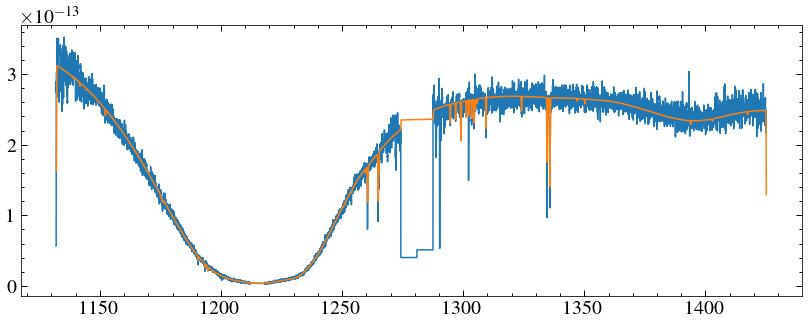

LM-COM
For the file /media/david/2tb_ext_hd/hddata/pcebs/hst/cos/ldlc04010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 4
CENWAVE = 1291
DISPTAB = 2bj2256ml_disp.fits
10.080480600258259


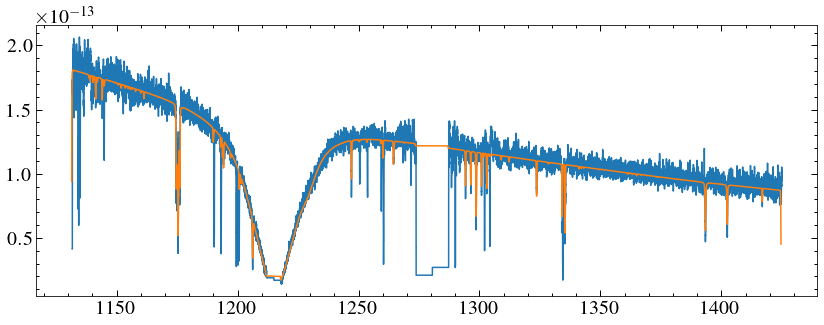

WD0137-349
For the file /media/david/2tb_ext_hd/hddata/pcebs/hst/cos/ldlc06010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 4
CENWAVE = 1291
DISPTAB = 2bj2256ml_disp.fits
13.707509500976819


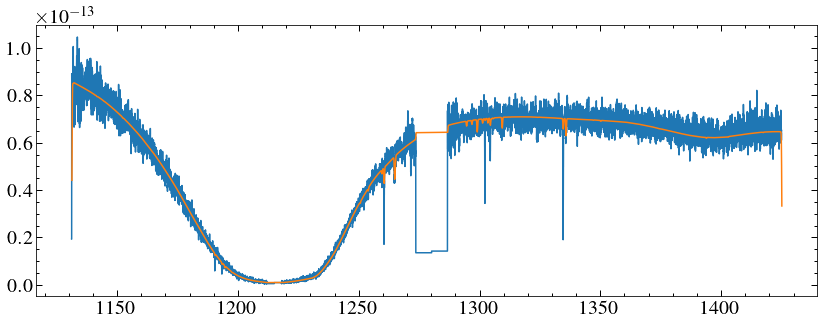

EGGR-38
For the file /media/david/2tb_ext_hd/hddata/pcebs/hst/cos/ldlc07010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 4
CENWAVE = 1291
DISPTAB = 2bj2256ml_disp.fits
23.002671180922974


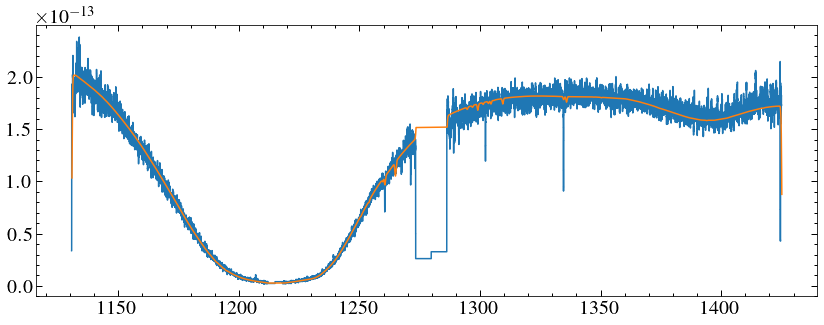

WD1339+606
For the file /media/david/2tb_ext_hd/hddata/pcebs/hst/cos/ldlc08010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 4
CENWAVE = 1291
DISPTAB = 2bj2256ml_disp.fits
1.5363274704192753


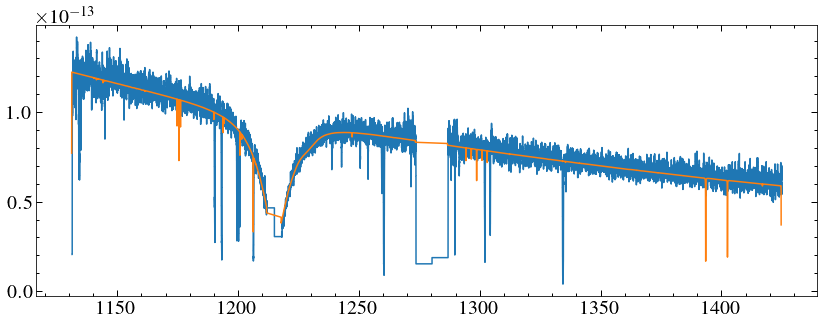

WD1436-216
For the file /media/david/2tb_ext_hd/hddata/pcebs/hst/cos/ldlc09010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 4
CENWAVE = 1291
DISPTAB = 2bj2256ml_disp.fits
6.895742224759302


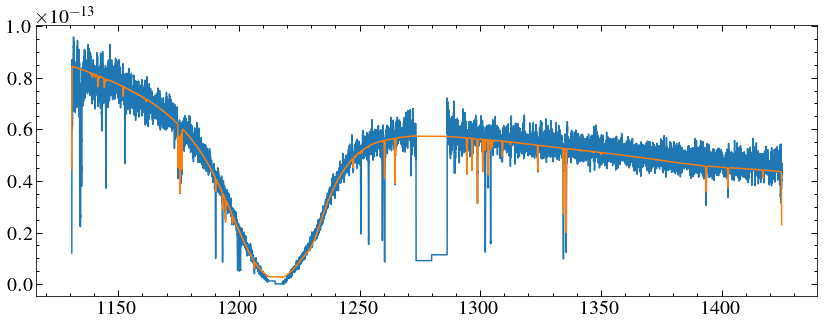

WD1458+171
For the file /media/david/2tb_ext_hd/hddata/pcebs/hst/cos/ldlc10010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 4
CENWAVE = 1291
DISPTAB = 2bj2256ml_disp.fits
28.164191372634598


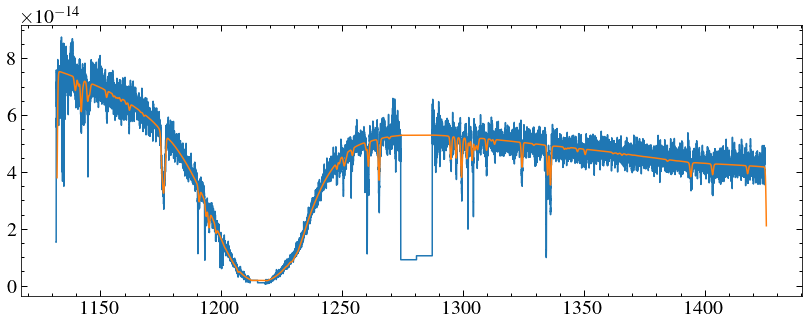

WD1504+546
For the file /media/david/2tb_ext_hd/hddata/pcebs/hst/cos/ldlc11010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 4
CENWAVE = 1291
DISPTAB = 2bj2256ml_disp.fits
6.270606339844457


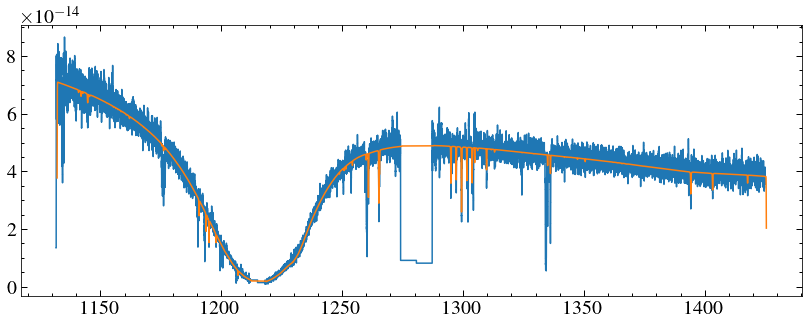

WD2317+268
For the file /media/david/2tb_ext_hd/hddata/pcebs/hst/cos/ldlc12010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 4
CENWAVE = 1291
DISPTAB = 2bj2256ml_disp.fits
8.282414737946953


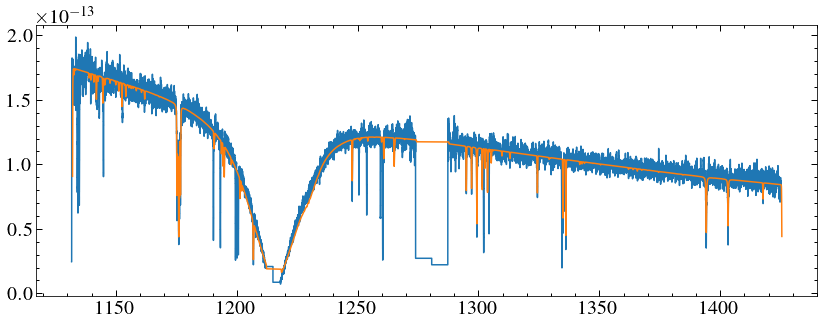

In [9]:
def residuals(scale, f, mf):
    return f - mf/scale

smooth  = 5
for x in x1ds:
    hdr = fits.getheader(x, 0)
    star = hdr['TARGNAME']
    if star[0] == 'V':
        star = star[2:]
    if star[0:3] == 'WD-':
        star =  star.replace('-', '', 1)
    mod = glob.glob('{}{}*.dk'.format(modpath, star))
    if star != 'CC-Cet' and len(mod) > 0: # CC Cet already published
    # if star == 'LM-COM':
        print(star)
        mod = mod[0]
        mw, mf = np.loadtxt(mod, unpack=True, skiprows= 40 )
        mask = (mw > 1130) & (mw < 1425)
        mw, mf = mw[mask], mf[mask]
        
        datadir = Path('/media/david/2tb_ext_hd/hddata/cos_lsfs')
        LSF_file_name, disptab_path = lsf.get_lsf_file(x, datadir)
        lsfpath = '{}/{}'.format(datadir, LSF_file_name)

        mwc, mfc = lsf.convolve_lsf(mw, mf, 1291, lsfpath, disptab_path, detector="FUV")
        
        wc = np.array([], dtype = float)
        fc = np.array([], dtype = float)
        ec = np.array([], dtype = float)
        data = fits.getdata(x,1)
        for dt in data[::-1]:
            wc = np.concatenate((wc, dt['WAVELENGTH']))
            fc = np.concatenate((fc, dt['FLUX']))
            ec = np.concatenate((ec, dt['ERROR']))
        
        fc = convolve(fc,Box1DKernel(smooth))
        ec = convolve(ec,Box1DKernel(smooth))/smooth**0.5
        mask = (wc > 1130) & (wc < 1212) | (wc > 1218) & (wc < 1425)
        wc, fc, ec = wc[mask], fc[mask], ec[mask]
        mask = fc > 0
        wc, fc, ec = wc[mask], fc[mask], ec[mask]
        
        mf= interp1d(mw, mf, fill_value='extrapolate')(wc)
        
        vrow = vtab[np.where(vtab['Name'] == star)[0][0]]
        vrad = vrow['Vrad']
        if star == 'WD1504+546':
            vrad = 105 #value in table clearly wrong, tae
        mw = (vrad*u.km/u.s).to(u.AA, equivalencies=u.doppler_optical(wc*u.AA)).value
        
        vsini = vrow['Vsini']
        vang = (vsini*u.km/u.s).to(u.AA, equivalencies=u.doppler_optical(np.mean(wc)*u.AA)).value - np.mean(wc)
        vpix =  vang / (wc[-1]- wc[0])*len(wc)
        print(vpix)
        mf  =  convolve(mf, Gaussian1DKernel(stddev=vpix))
    
        
    
        normfac = leastsq(residuals, 1., args=(fc, mf))[0]

        # plt.plot(wc, fc/np.median(fc))
        plt.step(wc, fc, where='mid')
        plt.plot(mw, mf/normfac)
        


        # plt.plot(mw, mf/np.median(mf))
        # plt.plot(mwc, mfc/np.median(mfc))

        # plt.xlim(1290, 1310)
       
        plt.show()
        


Need to implement a doppler shift and orbital broadening.

TypeError: interp_am() missing 1 required positional argument: 'self'